# Homework 8

We have learned about the basics of using machine learning and deep learning for many computer vision problems, including object classification, semantic segmentation, object detection, etc. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `conda install pytorch torchvision -c pytorch` in your virtual environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`. 

As a quick refresher question. Why do we want to split our data into training and testing sets?

**Answer:**<br>
After a model is trained using the training data, we also want to make sure that the model is good enough for unseen data. Therefore, the data is split into training and testing sets. The test set is used only once, acting as a last gate to deployment, to make sure that the model is good enough for unseen data.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10, so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

Why do we want to normalize the images beforehand?

*HINT*: consider the fact that the network we developed will be deployed to a large number of images. 

**Answer:**<br>
Since the network we developed will be deployed to a large number of image, pixels values in different images is very likely to have different scales. For example, the first image have values range from 0 to 10 while the second image has value range from 0 to 100. Therefore, normalization of the image will ensure generalization. By normalizing all of our inputs to a standard scale, we're allowing the network to more quickly learn the optimal parameters for each input node.

In [2]:
trainloader = None
testloader = None
batch_size = 4

### YOUR CODE HERE
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
### END YOUR CODE

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# running this block will take a few minutes to download the dataset if you haven't done so

Files already downloaded and verified
Files already downloaded and verified


Let's plot out some training images to see what we are dealing with:

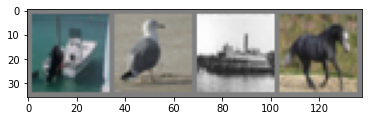

 ship  bird  ship horse


In [3]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output.

In [4]:
from network import Net

net = Net()

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start). 

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take just several minutes on your CPU.

In [6]:
epoch_num = 2
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.272
[1,  4000] loss: 1.903
[1,  6000] loss: 1.673
[1,  8000] loss: 1.586
[1, 10000] loss: 1.523
[1, 12000] loss: 1.466
[2,  2000] loss: 1.388
[2,  4000] loss: 1.357
[2,  6000] loss: 1.360
[2,  8000] loss: 1.324
[2, 10000] loss: 1.307
[2, 12000] loss: 1.270
Finished Training


The last step of training is to save the trained model locally to a checkpoint:

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

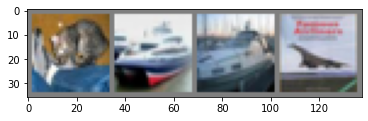

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [9]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE
outputs = net(images)
i, predicted = torch.max(outputs, 1)
### END YOUR CODE
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


How does your prediction look like? Does that match your expectation? Write a few sentences to describe what you got and provide some analysis if you have any.

**Answer:**<br>
Two of the four predictions are correct. Considering this is a very simple CNN model with just a few layers and the resolution of the image is bad, the performace achieved by this model is pretty good.

Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        ### YOUR CODE HERE
        outputs = net(images)
        i, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        ### END YOUR CODE

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better?

**Answer:**<br>
As there is 10 classes, random guessing would get an accuracy of $10\%$. Therefore, this model performs significantly better since it achieves an accuracy of $55\%$.

Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # repeat what you did previously, but now for each class
        ### YOUR CODE HERE
        outputs = net(images)
        i, predictions = torch.max(outputs, 1)
        for l, p in zip(labels, predictions):
            if l == p:
                correct_pred[classes[l]] += 1
            total_pred[classes[l]] += 1
        ### END YOUR CODE

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 64.6 %
Accuracy for class car   is: 75.5 %
Accuracy for class bird  is: 18.7 %
Accuracy for class cat   is: 46.3 %
Accuracy for class deer  is: 46.9 %
Accuracy for class dog   is: 50.3 %
Accuracy for class frog  is: 72.7 %
Accuracy for class horse is: 59.7 %
Accuracy for class ship  is: 64.5 %
Accuracy for class truck is: 56.7 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance as much as possible. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not?

## **Answer:**
### I. Tuning the architecture
For tuning the architecture, I started by adding more layers bacause a deeper model tends to achieve a higher performance. Initially, the deep learning model contains 2 convlutional layers and 2 fully connected layers. As shown in the table below, by adding one convolutional layer, the accuracy on test set is increased from 55% to 57%. To further increase the accuracy, I added one more convolutional layer. However, the accuracy on test set is still 57%. It seems that further increasing the number of convolutional layers will not help. Therefore, I decided to increase the number of fully connected layers.

After I added one fully connected layer to the model, the accuracy on test set decreased to 49%. Therefore, adding fully connected layers cannot improve model performance.

<table style="width:100%">
  <tr>
    <th>Number of Convolutional Layer</th>
    <th>Number of of Fully Connected Layer</th>
    <th>Accuracy on Test Image</th>
  </tr>
   <tr>
    <td>2</td>
    <td>2</td>
    <td>55%</td>
  </tr>
  <tr>
    <td>3</td>
    <td>2</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>4</td>
    <td>2</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>4</td>
    <td>3</td>
    <td>49%</td>
  </tr>
  
</table> 

Using the configuration with highest performance in the previous experiment, I tired to improve the accuracy by increasing the number of filters in each layer. Finally, I found out that doubling the filters in each layer can improve the accuracy from 57% to 61%.

<table style="width:100%">
  <tr>
    <th># Filters in Layer 1</th>
    <th># Filters in Layer 2</th>
    <th># Filters in Layer 3</th>
    <th># Filters in Layer 4</th>
    <th>Accuracy on Test Image</th>
  </tr>
   <tr>
    <td>6</td>
    <td>16</td>
    <td>32</td>
    <td>64</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>16</td>
    <td>32</td>
    <td>64</td>
    <td>128</td>
    <td>61%</td>
  </tr>
</table> 

### II. Add Regulation(Dropout)
In the previous step, by tuning architecture, I got a model that has 61% accuracy on test set. Based on that model, I added one dropout layer as regulation to prevent overfitting. Table below shows the performance of each model with different dropout rate. Based on the table, I choose to implement 0.2 as the dropout rate since it helps prevent overfitting without hurting the accuracy.

<table style="width:100%">
  <tr>
    <th>Dropout Rate</th>
    <th>Accuracy on Test Image</th>
  </tr>
   <tr>
    <td>No Dropout</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>0.4</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>0.3</td>
    <td>59%</td>
  </tr>
  <tr>
    <td>0.2</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.1</td>
    <td>59%</td>
  </tr>
</table> 

### III. Tuning Learning Rate and Learning Rate Decay
In the previous steps, the model achieves a accuracy of 61% on test set. In this section, I'm trying to improve the model performance by tuning learning rate and learning rate decay. A higher learning rate means that the model can learning faster. As shown in the table below, I tried various combination of learning rate and learning rate decay. It turns out that learning rate = 0.001 and learnign rate decay = 0.00001 is the best choice, which helps the model to achieves a 63% accuracy on test set.

<table style="width:100%">
  <tr>
    <th>Learning Rate</th>
    <th>Learning Rate Decay</th>
    <th>Accuracy on Test Image</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>0</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.001</td>
    <td>0.00001</td>
    <td>63%</td>
  </tr>
  <tr>
    <td>0.001</td>
    <td>0.0001</td>
    <td>60%</td>
  </tr>
  <tr>
    <td>0.001</td>
    <td>0.001</td>
    <td>57%</td>
  </tr>
  <tr>
    <td>0.002</td>
    <td>0</td>
    <td>62%</td>
  </tr>
  <tr>
    <td>0.002</td>
    <td>0.00001</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.002</td>
    <td>0.0001</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.002</td>
    <td>0.001</td>
    <td>61%</td>
  </tr>
  <tr>
    <td>0.003</td>
    <td>0</td>
    <td>58%</td>
  </tr>
  <tr>
    <td>0.003</td>
    <td>0.00001</td>
    <td>58%</td>
  </tr>
  <tr>
    <td>0.003</td>
    <td>0.0001</td>
    <td>58%</td>
  </tr>
  <tr>
    <td>0.003</td>
    <td>0.001</td>
    <td>59%</td>
  </tr>
  <tr>
    <td>0.004</td>
    <td>0</td>
    <td>52%</td>
  </tr>
  <tr>
    <td>0.004</td>
    <td>0.00001</td>
    <td>52%</td>
  </tr>
  <tr>
    <td>0.004</td>
    <td>0.0001</td>
    <td>55%</td>
  </tr>
  <tr>
    <td>0.004</td>
    <td>0.001</td>
    <td>55%</td>
  </tr>
</table> 

### IV. Tuning Number of epoch
Finally, I tried to improve the model performance by tuning the number of epoch. From the table below, it seems like the accuracy on test set will not increase after the fourth epoch. Therefore, training the model for 4 epoch is good enough.

<table style="width:100%">
  <tr>
    <th>Number of Epoch</th>
    <th>Accuracy on Test Image</th>
  </tr>
  <tr>
    <td>2</td>
    <td>63%</td>
  </tr>
  <tr>
    <td>3</td>
    <td>65%</td>
  </tr>
  <tr>
    <td>4</td>
    <td>70%</td>
  </tr>
  <tr>
    <td>5</td>
    <td>70%</td>
  </tr>
  <tr>
    <td>6</td>
    <td>70%</td>
  </tr>
</table>

## 2. Extra Credit: further improve your model performance

You have just tried tuning the hyper-parameters to improve your model performance. It's a very important part but not all! In this section, you are encouraged to read online to explore other options to further enhance your model. You may or may not need additional compute resources depending on what you do. But if you do need GPUs, Google Colab could be a great point to start.

Since this a free-form section, you should report here in detail what you have done, and feel free to submit any additional files if needed (e.g., additional code files). We'll be grading based on the effort you spend and the performance you achieved.

**Answer:**<br>
Using the architecture shown in the image below, I improved the accuracy of the model from 70% to 74%. The learning rate is 0.001, and the number of epoch is 8.

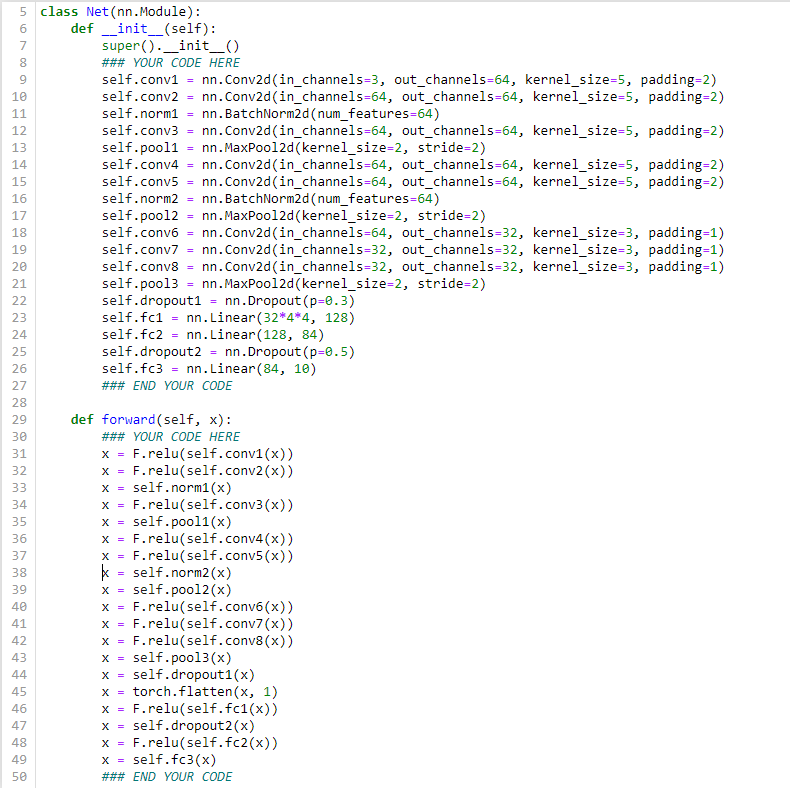

In [24]:
from IPython.display import Image
Image('Extra.png')